In [1]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

In [2]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

In [3]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        NUM_GPRS = NUM_REGS
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y

In [4]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

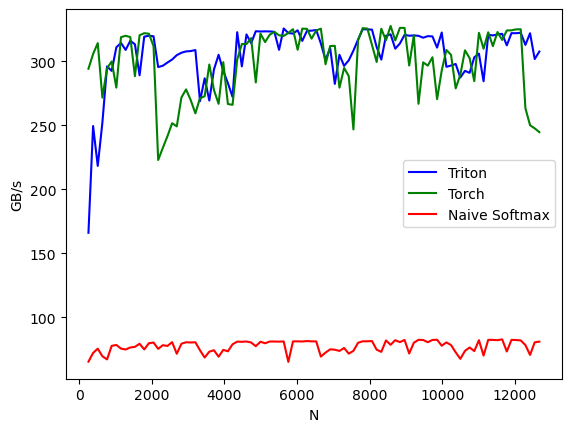

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0  165.952978  294.220051      65.192700
1     384.0  249.434709  305.750603      71.958211
2     512.0  218.246884  314.275039      75.370564
3     640.0  252.103729  271.644626      69.390970
4     768.0  296.042614  294.611035      66.928581
5     896.0  292.542403  299.901219      77.552792
6    1024.0  310.973358  279.472549      78.253547
7    1152.0  314.378526  318.880974      75.390116
8    1280.0  308.927248  320.022975      74.695484
9    1408.0  316.094349  318.982587      76.256125
10   1536.0  313.355279  288.413094      76.768438
11   1664.0  289.092934  320.406279      79.192873
12   1792.0  319.301223  322.017370      74.752177
13   1920.0  320.048933  321.606329      79.581094
14   2048.0  319.616753  311.973754      80.161341
15   2176.0  295.522110  222.862161      75.219128
16   2304.0  296.587227  232.355333      78.074988
17   2432.0  299.082111  241.527814      77.469521
18   2560.

In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

## Reference
1. https://triton-lang.org/main/getting-started/tutorials/02-fused-softmax.html